In [2]:
# Librerías
import pandas as pd
from sklearn.model_selection import train_test_split
# Warnings
import warnings
warnings.filterwarnings('ignore')
# Internal tool and helpers
import model_helpers as mh
import xgboost as xgb

In [3]:
data_path = "../CHESS/data/df_3_cod.csv"
df_3 = pd.read_csv(data_path)

In [7]:
# X e Y 
X = df_3.copy()
y_name = "winner_cod"
# X es el dataframe eliminando la variable de salida. Eliminando también 'moves' que ya está representado
X = X.drop(columns=['rated','winner',y_name, 'current_turn','time_increment','opening_code','opening_fullname','opening_shortname','opening_variation','moves_fen'])
X = X.drop(columns=['game_id', 'white_rating', 'black_rating', 'moves', 'current_turn_cod', 'opening_moves', 'rated_cod', 'current_turn_cod', 'time_increment_cod', 'opening_code_cod', 'opening_fullname_cod', 'opening_shortname_cod', 'opening_variation_cod', 'moves_fen_cod'])# Y es un array unidimensional (ravel) de la variable de salida
Y = df_3[y_name].ravel()
X.columns

Index(['turns', 'w_ctrld_pawn', 'w_ctrld_knight', 'w_ctrld_bishop',
       'w_ctrld_rook', 'w_ctrld_queen', 'w_ctrld_king', 'w_preassure_points',
       'w_ctrld_diagonals', 'w_ctrld_lines', 'b_ctrld_pawn', 'b_ctrld_knight',
       'b_ctrld_bishop', 'b_ctrld_rook', 'b_ctrld_queen', 'b_ctrld_king',
       'b_preassure_points', 'b_ctrld_diagonals', 'b_ctrld_lines'],
      dtype='object')

In [8]:
# división en train y test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.3)
X_train.columns

Index(['turns', 'w_ctrld_pawn', 'w_ctrld_knight', 'w_ctrld_bishop',
       'w_ctrld_rook', 'w_ctrld_queen', 'w_ctrld_king', 'w_preassure_points',
       'w_ctrld_diagonals', 'w_ctrld_lines', 'b_ctrld_pawn', 'b_ctrld_knight',
       'b_ctrld_bishop', 'b_ctrld_rook', 'b_ctrld_queen', 'b_ctrld_king',
       'b_preassure_points', 'b_ctrld_diagonals', 'b_ctrld_lines'],
      dtype='object')

# XGboost

In [10]:
hp.quniform('max_depth', 2, 8, 1)

In [20]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK
from sklearn.metrics import accuracy_score
import numpy as np

# Define the hyperparameter space
space = {
    'max_depth': hp.choice('max_depth', np.arange(1, 14, dtype=int)),
    'learning_rate': hp.loguniform('learning_rate', -5, -2),
    'subsample': hp.uniform('subsample', 0.5, 1)
}

# Define the objective function to minimize
def objective(params):
    xgb_model = xgb.XGBClassifier(**params)
    xgb_model.fit(X_train, Y_train)
    y_pred = xgb_model.predict(X_test)
    score = accuracy_score(Y_test, y_pred)
    return {'loss': -score, 'status': STATUS_OK}

# Perform the optimization
best_params = fmin(objective, space, algo=tpe.suggest, max_evals=250)
print("Best set of hyperparameters: ", best_params)

100%|██████████| 100/100 [01:02<00:00,  1.61trial/s, best loss: -0.9181929181929182]
Best set of hyperparameters:  {'learning_rate': 0.1264091236549188, 'max_depth': 8, 'subsample': 0.9033702869729666}


In [21]:
# Crear un clasificador XGBoost
xgboost = xgb.XGBClassifier(**best_params)
# Entrenar el modelo en los datos de entrenamiento
xgboost.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1264091236549188,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


Performance del modelo de Prueba Xgboost características blancas y negras
 Accu 0.9159253444967731 
 Prec 0.9160510447338686 
 Reca 0.9159253444967731 
 Matriz de confusión:
 [[2468  273]
 [ 209 2783]]

Métricas de Probabilidad:
 Brier Score: 0.06093570567513042


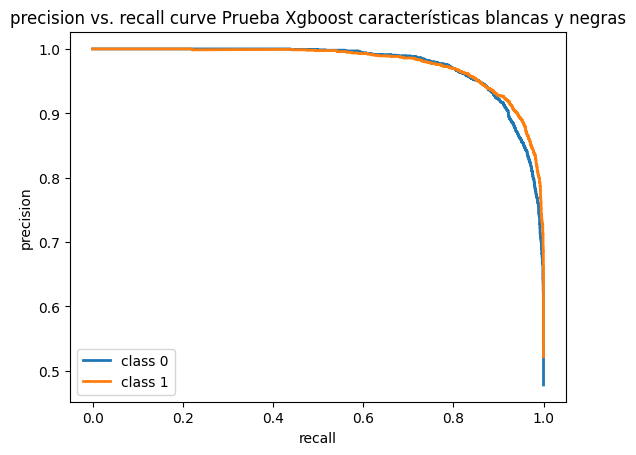

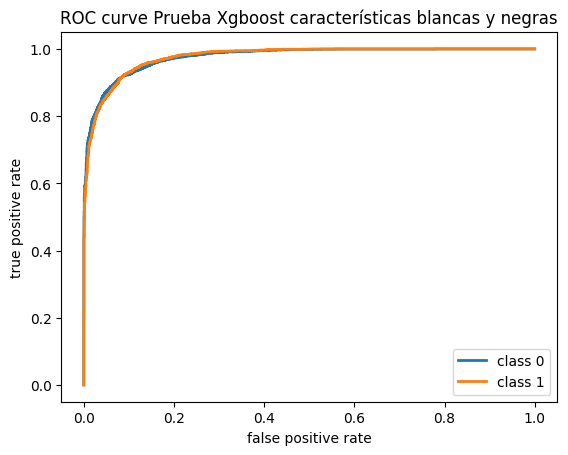


Performance del modelo de Entrenamiento Xgboost características blancas y negras
 Accu 0.9872897196261682 
 Prec 0.9872968042997405 
 Reca 0.9872897196261682 
 Matriz de confusión:
 [[6266  100]
 [  70 6939]]

Métricas de Probabilidad:
 Brier Score: 0.014989353585240697


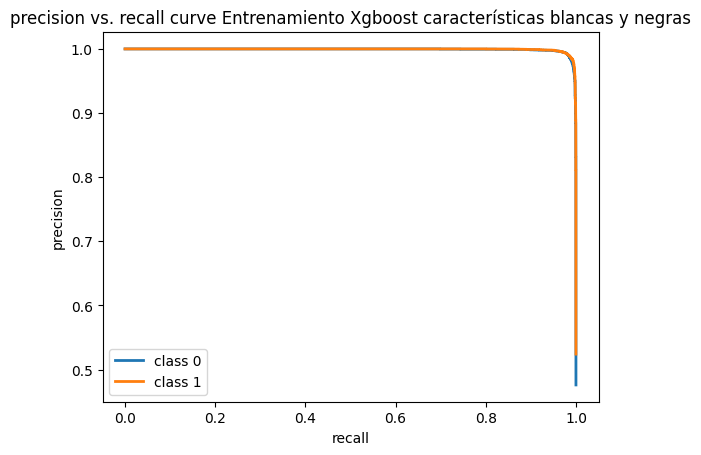

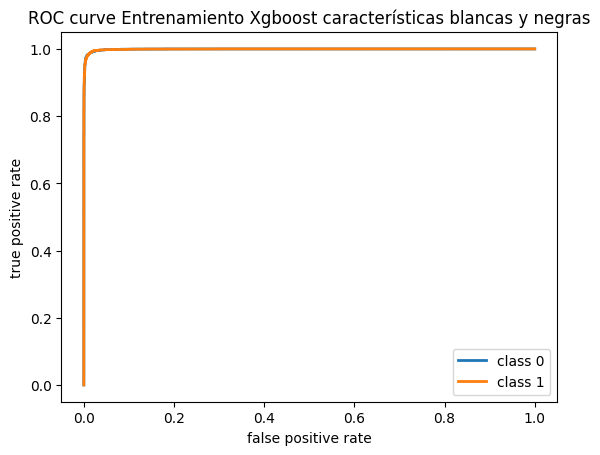

(0.9872897196261682,
 0.9872968042997405,
 0.9872897196261682,
 0.014989353585240697,
 array([[6266,  100],
        [  70, 6939]], dtype=int64))

In [22]:
Yhat_xgboost_test = xgboost.predict(X_test)
Yhat_xgboost_train = xgboost.predict(X_train)
Yhat_xgboost_test_prob = xgboost.predict_proba(X_test)
Yhat_xgboost_train_prob = xgboost.predict_proba(X_train)
mh.eval_perform_multi_class(Y_test,Yhat_xgboost_test, Yhat_xgboost_test_prob,2,"Prueba Xgboost características blancas y negras")
mh.eval_perform_multi_class(Y_train,Yhat_xgboost_train, Yhat_xgboost_train_prob,2,"Entrenamiento Xgboost características blancas y negras")

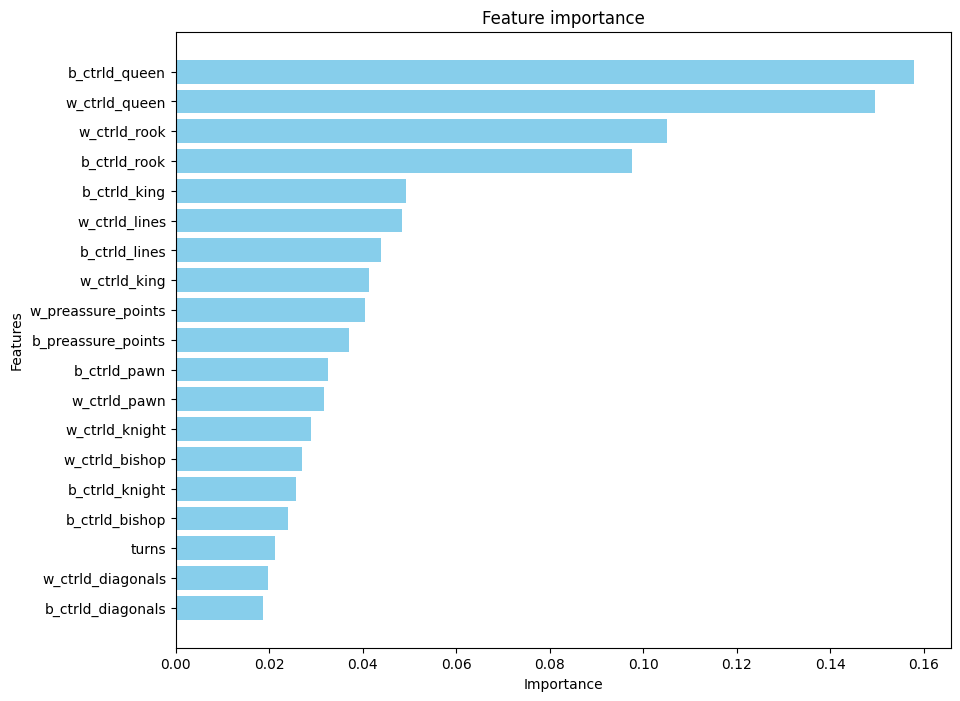

In [7]:
import matplotlib.pyplot as plt
# Feature importance
importance = xgboost.feature_importances_

df_importancia = pd.DataFrame({
    'Caracteristica': X.columns,
    'Importancia': importance
})

umbral = 0
# Filtrar los nombres de las características importantes
df_importancia = df_importancia[df_importancia['Importancia'] > umbral]
df_importancia = df_importancia.sort_values(by='Importancia', ascending=True)

features = df_importancia['Caracteristica']
importance = df_importancia['Importancia']


# Crear un gráfico de barras horizontal
plt.figure(figsize=(10, 8))
plt.barh(features, importance, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature importance')
plt.show()

In [17]:
import extract_features as ef
fen = '3r2k1/3r1p1p/6p1/1Q6/P3p1b1/2P3N1/2q2PPP/R1R3K1 b - - 0 24'
moves = 4
new_sample_df = ef.count_all_features(fen, moves)
new_sample_df.T

,0
turns,4
w_ctrld_pawn,7
w_ctrld_knight,6
w_ctrld_bishop,0
w_ctrld_rook,8
w_ctrld_queen,21
w_ctrld_king,2
w_preassure_points,7
w_ctrld_diagonals,2
w_ctrld_lines,5


In [14]:
# Human readable
ef.get_all_features(fen, moves).T

,0
turns,4
w_ctrld_pawn,"['b4', 'b5', 'd4', 'e3', 'f3', 'g3', 'h3']"
w_ctrld_knight,"['Ne2', 'Nf1', 'Nf5', 'Nh1', 'Nh5', 'Nxe4']"
w_ctrld_bishop,[]
w_ctrld_rook,"['Ra2', 'Ra3', 'Rab1', 'Rcb1', 'Rd1', 'Re1', '..."
w_ctrld_queen,"['Qa5', 'Qa6', 'Qb1', 'Qb2', 'Qb3', 'Qb4', 'Qb..."
w_ctrld_king,"['Kf1', 'Kh1']"
w_preassure_points,"['b1', 'b4', 'e2', 'f1', 'f5', 'h1', 'h5']"
w_ctrld_diagonals,{'b5': 2}
w_ctrld_lines,"{'a1': 1, 'c1': 1, 'b5': 3}"


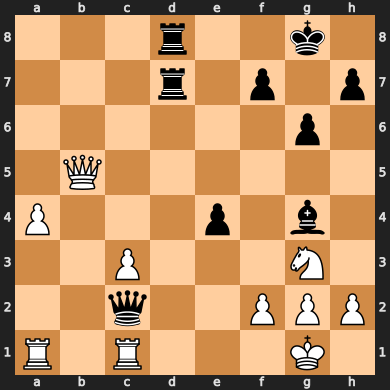

In [15]:
from chess import Board
# Mostrar el tablero de la primera cadena fen
board = Board(fen)
board

In [16]:
prob = xgboost.predict_proba(new_sample_df)
print(xgboost.classes_) # 0: negras. 1: empate. 2. blancas
print(f"Negras: {'{:.6f}'.format(prob[0][0])}. Empate:{'{:.6f}'.format(prob[0][1])}. Blancas:{'{:.6f}'.format(prob[0][2])}")


[0 1 2]
Negras: 0.761064. Empate:0.030369. Blancas:0.208567


In [12]:
import pickle
pickle.dump(xgboost, open("./pickles/models/xgoboost_model0410.pkl", 'wb'))